<a href="https://colab.research.google.com/github/alexiej/laboratory/blob/master/30_02_Voie_Translation_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from IPython.display import Audio
from scipy.io import wavfile

print("Tensorflow version: ", tf.__version__)
print("Pytorch version: ", torch.__version__)
print("GPU ON: ", torch.cuda.is_available())
 
!nvidia-smi

TensorFlow 2.x selected.
Tensorflow version:  2.1.0
Pytorch version:  1.4.0
GPU ON:  True
Tue Mar 17 09:43:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### **!!! IMPORTANT !!!**

---

If you run this first time, uncomment info about `git clone`, it requires 168 MB on you gdrive to get DATASET

In [3]:
#!git clone https://github.com/andabi/deep-voice-conversion.git '/content/drive/My Drive/deep-voice-conversion'
#!mkdir '/content/drive/My Drive/deep-voice-output'

!ln -s '/content/drive/My Drive/deep-voice-conversion' /content/deep-voice-conversion
!ln -s '/content/drive/My Drive/deep-voice-output' /content/deep-voice-output

FOLDER_DATASET = '/content/deep-voice-conversion/datasets/arctic'

DATASET_SOURCE = FOLDER_DATASET + '/bdl'
DATASET_DEST = FOLDER_DATASET + '/slt'

print("DATASET INPUT SOURCE:")
!ls {DATASET_SOURCE} | head -5

print("DATASET INPUT DEST:")
!ls {DATASET_DEST}   | head -5

FOLDER_OUTPUT = '/content/deep-voice-output'

print("DATASET AND MODEL OUTPUT:")
!ls {FOLDER_OUTPUT}

DATASET INPUT SOURCE:
arctic_a0001.wav
arctic_a0002.wav
arctic_a0003.wav
arctic_a0004.wav
arctic_a0005.wav
DATASET INPUT DEST:
arctic_a0001.wav
arctic_a0002.wav
arctic_a0003.wav
arctic_a0004.wav
arctic_a0005.wav
DATASET AND MODEL OUTPUT:


## 1.0 Installl Libraries

In [4]:
!pip install pydub

## 2.0 Files / Utilities

In [0]:
from types import SimpleNamespace

DEFAULT_FS = 22050
SAMPLE_RATE = DEFAULT_FS

hparams = SimpleNamespace(
    # for spectogram
    preemphasis=0.97,
    max_abs_value=4,
    power=1.5,
    griffin_lim_iters=60,

    #for melspectogram
    num_freq=513,

    # Audio:
    sample_rate=DEFAULT_FS,

    # this is only valid for mulaw is True
    silence_threshold=2,
    num_mels=160, # double it, to fit the size
    fmin=125,
    fmax=7600,
    fft_size=2048,

    # shift can be specified by either hop_size or frame_shift_ms
    hop_size=256,
    frame_shift_ms=None,
    min_level_db=-100,
    ref_level_db=20,
)

## 2.1 wavutils.py

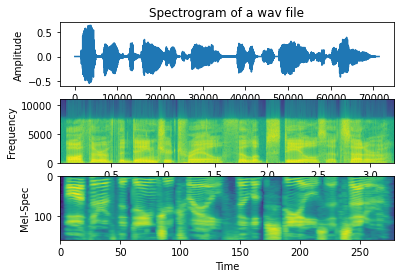

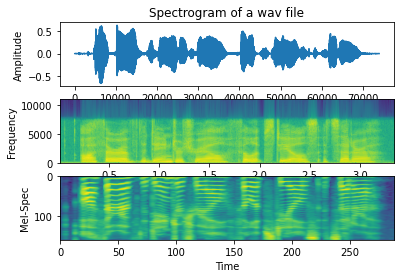

In [85]:
# %%writefile wavutils.py
import os
import argparse
import sys

import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
from IPython.display import Audio
import numpy as np
import sys

import librosa
from scipy.io import wavfile
from scipy import signal

# ==== HELPERS===============================================

# Based on https://github.com/librosa/librosa/issues/434
def _griffin_lim(S):
    angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
    S_complex = np.abs(S).astype(np.complex)
    for i in range(hparams.griffin_lim_iters):
        if i > 0:
            angles = np.exp(1j * np.angle(_stft(y)))
        y = _istft(S_complex * angles)
    return y


def _stft(y):
    return librosa.stft(y=y, n_fft=hparams.fft_size, hop_length=get_hop_size())


def _istft(y):
    return librosa.istft(y, hop_length=get_hop_size())


# Conversions:

_mel_basis = None
_inv_mel_basis = None


def _linear_to_mel(spectrogram):
    global _mel_basis
    if _mel_basis is None:
        _mel_basis = _build_mel_basis()
    return np.dot(_mel_basis, spectrogram)


def _mel_to_linear(mel_spectrogram):
    global _inv_mel_basis
    if _inv_mel_basis is None:
        _inv_mel_basis = np.linalg.pinv(_build_mel_basis())
    return np.maximum(1e-10, np.dot(_inv_mel_basis, mel_spectrogram))


def _build_mel_basis(n_mels=hparams.num_mels):
    # n_fft = (hparams.num_freq - 1) * 2
    return librosa.filters.mel(hparams.sample_rate,
                                hparams.fft_size,
                               fmin=hparams.fmin, fmax=hparams.fmax,
                               n_mels=n_mels)


def _amp_to_db(x):
    return 20 * np.log10(np.maximum(1e-5, x))


def _db_to_amp(x):
    return np.power(10.0, x * 0.05)


def _preemphasis(x):
    return signal.lfilter([1, -hparams.preemphasis], [1], x)


def _inv_preemphasis(x):
    return signal.lfilter([1], [1, -hparams.preemphasis], x)


def _normalize(S):
    return np.clip(
        (2 * hparams.max_abs_value) * ((S - hparams.min_level_db) / (-hparams.min_level_db)) - hparams.max_abs_value,
        -hparams.max_abs_value, hparams.max_abs_value)


def _denormalize(D):
    return (((np.clip(D, -hparams.max_abs_value,
                      hparams.max_abs_value) + hparams.max_abs_value) * -hparams.min_level_db / (
                     2 * hparams.max_abs_value))
            + hparams.min_level_db)


def get_hop_size():
    hop_size = hparams.hop_size
    if hop_size is None:
        assert hparams.frame_shift_ms is not None
        hop_size = int(hparams.frame_shift_ms / 1000 * hparams.sample_rate)
    return hop_size



# ===================================================== WAV
def wav_open(file):
    # data = wavfile.read(file)
    x,fs = librosa.load(file, sr=DEFAULT_FS)

    # Separete the object elements
    time      = np.arange(0,len(x))/fs
    wavdata = {
        'framerate': fs,
        'sounddata': x,
        'time': time
    }
    return wavdata

def wav_play(wavdata):
    return Audio(wavdata['sounddata'],rate=wavdata['framerate'])

def file_play(file):
    return wav_play(wav_open(file))


# ===================================================== SPECTOGRAM
def wav_to_spec(y):
    D = _stft(_preemphasis(y))
    S = _amp_to_db(np.abs(D)) - hparams.ref_level_db
    return _normalize(S)
    

def spec_to_wav(spectrogram):
    S = _db_to_amp(_denormalize(spectrogram) + hparams.ref_level_db)  # Convert back to linear
    return _inv_preemphasis(_griffin_lim(S ** hparams.power))  # Reconstruct phase


def spec_plot(spec_arr):
    plt.imshow(np.log(spec_arr)) # we need to logarithm soectogram to show.
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [ms]')
    plt.show()


# ===================================================== MEL SPECTOGRAM
def wav_to_mel(y, n_mels=hparams.num_mels):
    D = _stft(_preemphasis(y))
    if n_mels==hparams.num_mels:
        S = _amp_to_db(_linear_to_mel(np.abs(D)))
    else:
        _mel_basis = _build_mel_basis(n_mels)
        S = _amp_to_db(np.dot(_mel_basis, np.abs(D)))
    return _normalize(S)

def mel_to_wav(melspectrogram, n_mels=hparams.num_mels):
    if n_mels==hparams.num_mels:
        S = _mel_to_linear(_db_to_amp(_denormalize(melspectrogram)))  # Convert back to linear
    else:
        inv = np.linalg.pinv(_build_mel_basis(n_mels))
        S = np.maximum(1e-10, np.dot(inv, _db_to_amp(_denormalize(melspectrogram))))
    return _inv_preemphasis(_griffin_lim(S ** 1.5))  # Reconstruct phase


def mel_plot(mel_arr):
    return plt.imshow(mel_arr)


# ===================================================== TENSORFLOW
def mel_to_tf(mel_arr):
    # mel_arr = np.transpose(mel_arr, (1, 0))
    t = torch.from_numpy(mel_arr.astype(np.float32, copy=False) )
    t = t.expand(1,t.shape[0],t.shape[1])
    return t

def tf_to_mel(tf_arr):
    return tf_arr[0,:,:].cpu().numpy()

# =================================== WAVSHOW
import IPython.display as ipd

def wav_show(wavdata):
    x = wavdata['sounddata']
    fs = wavdata['framerate']

    ax = plt.subplot(311)
    plt.title('Spectrogram of a wav file')
    plt.plot(x)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(312)
    plt.specgram(x,Fs=fs)
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    ax = plt.subplot(313)
    mel_array = wav_to_mel(x)
    plt.imshow(mel_array, aspect="auto")
    plt.xlabel('Time') 
    plt.ylabel('Mel-Spec')

    plt.show()
    return ipd.display(Audio(x,rate=fs))

def file_shows(files):
    for f in files:
        wavdata = wav_open(f)
        wav_show(wavdata)


file_shows(
    [DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

In [38]:
fs, x = wavfile.read(FILE)

x.shape

(51761,)

In [6]:
# %%writefile wavutils.py
import os
import argparse
import sys

import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
from IPython.display import Audio

import numpy as np
import sys


def get_file(file):
    data = wavfile.read(file)
    # Separete the object elements
    framerate = data[0]
    sounddata = data[1]
    time      = np.arange(0,len(sounddata))/framerate
    wavdata = {
        'framerate': data[0],
        'sounddata': data[1],
        'time': time
    }
    return wavdata

def play_wavdata(wavdata):
    return Audio(wavdata['sounddata'],rate=wavdata['framerate'])

def play_file(file):
    return play_wavdata(get_file(file))


def show_file(file):
    samplingFrequency, signalData = wavfile.read(file)
    # Plot the signal read from wav file
    plt.subplot(211)
    plt.title('Spectrogram of a wav file')
    plt.plot(signalData)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.subplot(212)
    plt.specgram(signalData,Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    return play_file(file)

def to_spectogram(file):
    sample_rate, samples = wavfile.read(file)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    # plt.pcolormesh(times, frequencies, np.log(spectrogram))
    return spectrogram

def plot_spectogram(spectogram):
    plt.imshow(np.log(spectogram)) # we need to logarithm soectogram to show.
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


import IPython.display as ipd

def play_files(files):
    for f in files:
      ipd.display(play_file(f))


def show_files(files):
    for f in files:
      ipd.display(show_file(f))


Writing wavutils.py


In [7]:
from wavutils import to_spectogram,plot_spectogram, show_file, get_file, play_wavdata, play_file,play_files,show_files

play_files(
    [DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

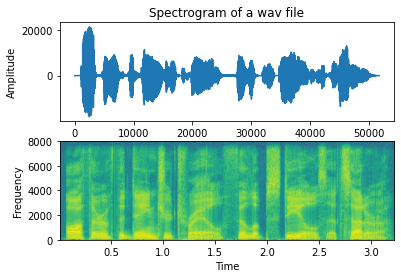

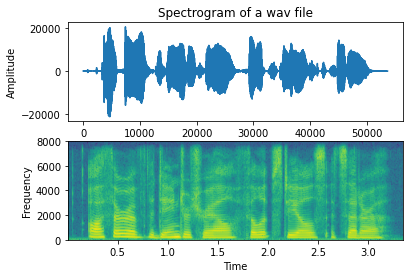

In [8]:
show_files(
    [DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

## 2.2 WavConverts

In [10]:
%%writefile wavconverts.py



Writing wavconverts.py


# 3.0 Data Import